In [69]:
import os
import json
import torch
from torch_geometric.data import Dataset, Data

class SingleFileEmbeddingPairDataset(Dataset):
    def __init__(self, json_path):
        super().__init__(os.path.dirname(json_path))
        # Load the JSON (which is a dict of model numbers)
        with open(json_path, 'r') as f:
            model_dict = json.load(f)
            # Flatten all model pairs into a list:
            self.all_pairs = []
            for model_num, pair in model_dict.items():
                # Optionally store model_num if you want it later: pair['model_num'] = model_num
                self.all_pairs.append(pair)

    def __len__(self):
        return len(self.all_pairs)

    def __getitem__(self, idx):
        pair = self.all_pairs[idx]

        # Extract embeddings for A and B
        A_ids = sorted(pair['A_embeddings'].keys(), key=lambda x: int(x))
        xA = torch.tensor([pair['A_embeddings'][xtid] for xtid in A_ids], dtype=torch.float)
        B_ids = sorted(pair['B_embeddings'].keys(), key=lambda x: int(x))
        xB = torch.tensor([pair['B_embeddings'][xtid] for xtid in B_ids], dtype=torch.float)

        # Dummy edge indices (empty for now)
        edge_indexA = torch.empty((2,0), dtype=torch.long)
        edge_indexB = torch.empty((2,0), dtype=torch.long)

        A_id_to_idx = {int(aid): idx for idx, aid in enumerate(A_ids)}
        B_id_to_idx = {int(bid): idx for idx, bid in enumerate(B_ids)}

        mappings = []
        for a, b in pair['mappings']:
            idx_a = -1 if a == 'NULL' else A_id_to_idx[int(a)]  
            idx_b = -1 if b == 'NULL' else B_id_to_idx[int(b)]
            mappings.append([idx_a, idx_b])

        matches = torch.tensor(mappings, dtype=torch.long)

        dataA = Data(x=xA, edge_index=edge_indexA, xt_entity_ids=A_ids)
        dataB = Data(x=xB, edge_index=edge_indexB, xt_entity_ids=B_ids)
        return dataA, dataB, matches

In [70]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GraphEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.conv3 = SAGEConv(hidden_dim, out_dim)
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return x

class SiameseGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.encoder = GraphEncoder(in_dim, hidden_dim, out_dim)
    def forward(self, data1, data2):
        h1 = self.encoder(data1.x, data1.edge_index)   # [N1, out_dim]
        h2 = self.encoder(data2.x, data2.edge_index)   # [N2, out_dim]
        return h1, h2

In [75]:
def contrastive_loss(emb1, emb2, matches, margin=1.0):
    # emb1: [N1, D]; emb2: [N2, D]; matches: [K,2]
    # Positive pairs: for (i1,i2) in matches
    pos1 = emb1[matches[:,0]]
    pos2 = emb2[matches[:,1]]
    dists = (pos1 - pos2).pow(2).sum(dim=1)
    pos_loss = dists.mean()
    # Negative pairs: random mismatches
    idx1 = torch.randint(0, emb1.size(0), (matches.size(0),))
    idx2 = torch.randint(0, emb2.size(0), (matches.size(0),))
    neg1 = emb1[idx1]
    neg2 = emb2[idx2]
    neg_dists = (neg1 - neg2).pow(2).sum(dim=1)
    neg_loss = F.relu(margin - neg_dists).mean()
    return pos_loss + neg_loss

In [72]:
def batch_accuracy(emb1, emb2, matches):
    # emb1: [N1, D], emb2: [N2, D], matches: [K,2]
    valid = matches[:,1] != -1
    indices1 = matches[valid, 0]
    indices2 = matches[valid, 1]

    if len(indices1) == 0:
        return None  # avoid NaN

    dists = torch.cdist(emb1, emb2)  # [N1, N2]
    # For each ground-truth emb1 index, which emb2 is closest
    min_indices = torch.argmin(dists[indices1], dim=1)
    correct = (min_indices == indices2).float()
    return correct.mean().item()

In [73]:
def batch_topk_accuracy(emb1, emb2, matches, k=5):
    valid = matches[:,1] != -1
    indices1 = matches[valid, 0]
    indices2 = matches[valid, 1]

    if len(indices1) == 0:
        return None

    dists = torch.cdist(emb1, emb2)

    actual_k = min(k, emb2.shape[0])
    if actual_k == 0:
        return None  # no candidates

    topk = torch.topk(-dists[indices1], actual_k, dim=1).indices
    correct = torch.any(topk == indices2.unsqueeze(1), dim=1).float()
    return correct.mean().item()

Found 134 dataset entries.


Epoch 1: 100%|██████████| 134/134 [00:00<00:00, 174.17it/s]


Epoch 1: Loss = 1.2168, Top-1 = 23.58%, Top-5 = 59.15%


Epoch 2: 100%|██████████| 134/134 [00:00<00:00, 151.09it/s]


Epoch 2: Loss = 1.0169, Top-1 = 23.92%, Top-5 = 59.98%


Epoch 3: 100%|██████████| 134/134 [00:01<00:00, 121.22it/s]


Epoch 3: Loss = 1.0030, Top-1 = 24.15%, Top-5 = 60.51%


Epoch 4: 100%|██████████| 134/134 [00:00<00:00, 176.85it/s]


Epoch 4: Loss = 0.9793, Top-1 = 24.14%, Top-5 = 61.21%


Epoch 5: 100%|██████████| 134/134 [00:00<00:00, 171.84it/s]


Epoch 5: Loss = 0.9727, Top-1 = 23.15%, Top-5 = 60.90%


Epoch 6: 100%|██████████| 134/134 [00:00<00:00, 186.68it/s]


Epoch 6: Loss = 0.9195, Top-1 = 23.32%, Top-5 = 60.97%


Epoch 7: 100%|██████████| 134/134 [00:00<00:00, 184.12it/s]


Epoch 7: Loss = 0.8930, Top-1 = 24.06%, Top-5 = 60.90%


Epoch 8: 100%|██████████| 134/134 [00:00<00:00, 194.93it/s]


Epoch 8: Loss = 0.8999, Top-1 = 23.12%, Top-5 = 60.49%


Epoch 9: 100%|██████████| 134/134 [00:00<00:00, 202.04it/s]


Epoch 9: Loss = 0.8661, Top-1 = 23.47%, Top-5 = 60.96%


Epoch 10: 100%|██████████| 134/134 [00:00<00:00, 205.12it/s]


Epoch 10: Loss = 0.8371, Top-1 = 24.31%, Top-5 = 60.71%


Epoch 11: 100%|██████████| 134/134 [00:00<00:00, 192.46it/s]


Epoch 11: Loss = 0.8608, Top-1 = 24.15%, Top-5 = 61.15%


Epoch 12: 100%|██████████| 134/134 [00:00<00:00, 208.98it/s]


Epoch 12: Loss = 0.8706, Top-1 = 24.43%, Top-5 = 61.12%


Epoch 13: 100%|██████████| 134/134 [00:00<00:00, 202.80it/s]


Epoch 13: Loss = 0.8582, Top-1 = 24.65%, Top-5 = 60.93%


Epoch 14: 100%|██████████| 134/134 [00:00<00:00, 178.96it/s]


Epoch 14: Loss = 0.8327, Top-1 = 24.14%, Top-5 = 60.83%


Epoch 15: 100%|██████████| 134/134 [00:00<00:00, 204.04it/s]


Epoch 15: Loss = 0.8464, Top-1 = 23.85%, Top-5 = 60.25%


Epoch 16: 100%|██████████| 134/134 [00:00<00:00, 194.56it/s]


Epoch 16: Loss = 0.8244, Top-1 = 24.34%, Top-5 = 61.07%


Epoch 17: 100%|██████████| 134/134 [00:00<00:00, 173.52it/s]


Epoch 17: Loss = 0.8411, Top-1 = 24.70%, Top-5 = 61.29%


Epoch 18: 100%|██████████| 134/134 [00:00<00:00, 200.08it/s]


Epoch 18: Loss = 0.8022, Top-1 = 23.72%, Top-5 = 61.12%


Epoch 19: 100%|██████████| 134/134 [00:00<00:00, 193.57it/s]


Epoch 19: Loss = 0.8425, Top-1 = 24.23%, Top-5 = 61.15%


Epoch 20: 100%|██████████| 134/134 [00:00<00:00, 201.58it/s]


Epoch 20: Loss = 0.8209, Top-1 = 24.39%, Top-5 = 61.56%


Epoch 21: 100%|██████████| 134/134 [00:00<00:00, 203.11it/s]


Epoch 21: Loss = 0.8103, Top-1 = 24.37%, Top-5 = 61.61%


Epoch 22: 100%|██████████| 134/134 [00:00<00:00, 202.04it/s]


Epoch 22: Loss = 0.8129, Top-1 = 25.15%, Top-5 = 62.03%


Epoch 23: 100%|██████████| 134/134 [00:00<00:00, 200.07it/s]


Epoch 23: Loss = 0.8027, Top-1 = 24.80%, Top-5 = 61.59%


Epoch 24: 100%|██████████| 134/134 [00:00<00:00, 194.70it/s]


Epoch 24: Loss = 0.7936, Top-1 = 24.71%, Top-5 = 61.50%


Epoch 25: 100%|██████████| 134/134 [00:00<00:00, 193.57it/s]


Epoch 25: Loss = 0.7930, Top-1 = 25.16%, Top-5 = 62.10%


Epoch 26: 100%|██████████| 134/134 [00:00<00:00, 201.43it/s]


Epoch 26: Loss = 0.7913, Top-1 = 24.15%, Top-5 = 61.51%


Epoch 27: 100%|██████████| 134/134 [00:00<00:00, 181.14it/s]


Epoch 27: Loss = 0.7786, Top-1 = 24.77%, Top-5 = 62.36%


Epoch 28: 100%|██████████| 134/134 [00:00<00:00, 195.55it/s]


Epoch 28: Loss = 0.7995, Top-1 = 24.96%, Top-5 = 61.85%


Epoch 29: 100%|██████████| 134/134 [00:00<00:00, 202.04it/s]


Epoch 29: Loss = 0.7861, Top-1 = 26.00%, Top-5 = 62.02%


Epoch 30: 100%|██████████| 134/134 [00:00<00:00, 205.29it/s]


Epoch 30: Loss = 0.7681, Top-1 = 24.98%, Top-5 = 62.37%


Epoch 31: 100%|██████████| 134/134 [00:00<00:00, 204.82it/s]


Epoch 31: Loss = 0.7728, Top-1 = 24.71%, Top-5 = 62.43%


Epoch 32: 100%|██████████| 134/134 [00:00<00:00, 207.36it/s]


Epoch 32: Loss = 0.7796, Top-1 = 24.89%, Top-5 = 62.57%


Epoch 33: 100%|██████████| 134/134 [00:00<00:00, 207.36it/s]


Epoch 33: Loss = 0.7583, Top-1 = 25.56%, Top-5 = 62.53%


Epoch 34: 100%|██████████| 134/134 [00:00<00:00, 209.47it/s]


Epoch 34: Loss = 0.7712, Top-1 = 24.04%, Top-5 = 61.30%


Epoch 35: 100%|██████████| 134/134 [00:00<00:00, 204.48it/s]


Epoch 35: Loss = 0.7399, Top-1 = 24.93%, Top-5 = 62.53%


Epoch 36: 100%|██████████| 134/134 [00:00<00:00, 205.92it/s]


Epoch 36: Loss = 0.7438, Top-1 = 24.55%, Top-5 = 62.43%


Epoch 37: 100%|██████████| 134/134 [00:00<00:00, 201.89it/s]


Epoch 37: Loss = 0.7535, Top-1 = 24.24%, Top-5 = 62.72%


Epoch 38: 100%|██████████| 134/134 [00:00<00:00, 207.36it/s]


Epoch 38: Loss = 0.7446, Top-1 = 24.32%, Top-5 = 62.77%


Epoch 39: 100%|██████████| 134/134 [00:00<00:00, 175.90it/s]


Epoch 39: Loss = 0.7398, Top-1 = 25.03%, Top-5 = 62.29%


Epoch 40: 100%|██████████| 134/134 [00:00<00:00, 191.50it/s]


Epoch 40: Loss = 0.7584, Top-1 = 24.80%, Top-5 = 61.96%


Epoch 41: 100%|██████████| 134/134 [00:00<00:00, 198.60it/s]


Epoch 41: Loss = 0.7580, Top-1 = 24.30%, Top-5 = 62.37%


Epoch 42: 100%|██████████| 134/134 [00:00<00:00, 205.92it/s]


Epoch 42: Loss = 0.7468, Top-1 = 25.14%, Top-5 = 62.67%


Epoch 43: 100%|██████████| 134/134 [00:00<00:00, 204.04it/s]


Epoch 43: Loss = 0.7458, Top-1 = 25.32%, Top-5 = 62.41%


Epoch 44: 100%|██████████| 134/134 [00:00<00:00, 202.04it/s]


Epoch 44: Loss = 0.7373, Top-1 = 25.59%, Top-5 = 62.59%


Epoch 45: 100%|██████████| 134/134 [00:00<00:00, 199.63it/s]


Epoch 45: Loss = 0.7217, Top-1 = 25.24%, Top-5 = 63.45%


Epoch 46: 100%|██████████| 134/134 [00:00<00:00, 209.64it/s]


Epoch 46: Loss = 0.7416, Top-1 = 25.32%, Top-5 = 62.57%


Epoch 47: 100%|██████████| 134/134 [00:00<00:00, 198.74it/s]


Epoch 47: Loss = 0.7468, Top-1 = 25.41%, Top-5 = 63.23%


Epoch 48: 100%|██████████| 134/134 [00:00<00:00, 207.68it/s]


Epoch 48: Loss = 0.7539, Top-1 = 24.61%, Top-5 = 63.04%


Epoch 49: 100%|██████████| 134/134 [00:00<00:00, 199.63it/s]


Epoch 49: Loss = 0.7389, Top-1 = 24.79%, Top-5 = 62.69%


Epoch 50: 100%|██████████| 134/134 [00:00<00:00, 197.72it/s]


Epoch 50: Loss = 0.7205, Top-1 = 25.24%, Top-5 = 62.59%


Epoch 51: 100%|██████████| 134/134 [00:00<00:00, 177.06it/s]


Epoch 51: Loss = 0.7140, Top-1 = 25.43%, Top-5 = 62.56%


Epoch 52: 100%|██████████| 134/134 [00:00<00:00, 187.87it/s]


Epoch 52: Loss = 0.7103, Top-1 = 25.21%, Top-5 = 62.80%


Epoch 53: 100%|██████████| 134/134 [00:00<00:00, 205.61it/s]


Epoch 53: Loss = 0.7277, Top-1 = 24.65%, Top-5 = 62.80%


Epoch 54: 100%|██████████| 134/134 [00:00<00:00, 202.96it/s]


Epoch 54: Loss = 0.7060, Top-1 = 25.25%, Top-5 = 62.58%


Epoch 55: 100%|██████████| 134/134 [00:00<00:00, 195.41it/s]


Epoch 55: Loss = 0.7345, Top-1 = 24.67%, Top-5 = 62.72%


Epoch 56: 100%|██████████| 134/134 [00:00<00:00, 201.89it/s]


Epoch 56: Loss = 0.7173, Top-1 = 25.27%, Top-5 = 62.44%


Epoch 57: 100%|██████████| 134/134 [00:00<00:00, 198.89it/s]


Epoch 57: Loss = 0.7027, Top-1 = 25.73%, Top-5 = 63.42%


Epoch 58: 100%|██████████| 134/134 [00:00<00:00, 199.04it/s]


Epoch 58: Loss = 0.7072, Top-1 = 25.40%, Top-5 = 62.55%


Epoch 59: 100%|██████████| 134/134 [00:00<00:00, 205.30it/s]


Epoch 59: Loss = 0.7060, Top-1 = 24.94%, Top-5 = 62.68%


Epoch 60: 100%|██████████| 134/134 [00:00<00:00, 187.60it/s]


Epoch 60: Loss = 0.7161, Top-1 = 24.92%, Top-5 = 62.85%


Epoch 61: 100%|██████████| 134/134 [00:00<00:00, 195.12it/s]


Epoch 61: Loss = 0.7193, Top-1 = 25.78%, Top-5 = 62.75%


Epoch 62: 100%|██████████| 134/134 [00:00<00:00, 161.29it/s]


Epoch 62: Loss = 0.7229, Top-1 = 25.12%, Top-5 = 63.11%


Epoch 63: 100%|██████████| 134/134 [00:00<00:00, 193.40it/s]


Epoch 63: Loss = 0.7032, Top-1 = 25.23%, Top-5 = 63.20%


Epoch 64: 100%|██████████| 134/134 [00:00<00:00, 187.35it/s]


Epoch 64: Loss = 0.7077, Top-1 = 25.32%, Top-5 = 63.12%


Epoch 65: 100%|██████████| 134/134 [00:00<00:00, 196.70it/s]


Epoch 65: Loss = 0.7365, Top-1 = 25.29%, Top-5 = 62.78%


Epoch 66: 100%|██████████| 134/134 [00:00<00:00, 194.80it/s]


Epoch 66: Loss = 0.7122, Top-1 = 25.63%, Top-5 = 62.84%


Epoch 67: 100%|██████████| 134/134 [00:00<00:00, 197.71it/s]


Epoch 67: Loss = 0.7078, Top-1 = 26.06%, Top-5 = 63.13%


Epoch 68: 100%|██████████| 134/134 [00:00<00:00, 203.11it/s]


Epoch 68: Loss = 0.7040, Top-1 = 25.64%, Top-5 = 62.91%


Epoch 69: 100%|██████████| 134/134 [00:00<00:00, 202.96it/s]


Epoch 69: Loss = 0.7081, Top-1 = 24.93%, Top-5 = 63.02%


Epoch 70: 100%|██████████| 134/134 [00:00<00:00, 198.30it/s]


Epoch 70: Loss = 0.7181, Top-1 = 24.84%, Top-5 = 63.56%


Epoch 71: 100%|██████████| 134/134 [00:00<00:00, 204.19it/s]


Epoch 71: Loss = 0.6950, Top-1 = 25.04%, Top-5 = 62.94%


Epoch 72: 100%|██████████| 134/134 [00:00<00:00, 201.28it/s]


Epoch 72: Loss = 0.6917, Top-1 = 25.44%, Top-5 = 63.42%


Epoch 73: 100%|██████████| 134/134 [00:00<00:00, 173.40it/s]


Epoch 73: Loss = 0.6979, Top-1 = 25.54%, Top-5 = 63.12%


Epoch 74: 100%|██████████| 134/134 [00:00<00:00, 199.49it/s]


Epoch 74: Loss = 0.6912, Top-1 = 26.00%, Top-5 = 63.55%


Epoch 75: 100%|██████████| 134/134 [00:00<00:00, 206.23it/s]


Epoch 75: Loss = 0.6831, Top-1 = 25.86%, Top-5 = 63.42%


Epoch 76: 100%|██████████| 134/134 [00:00<00:00, 196.56it/s]


Epoch 76: Loss = 0.6928, Top-1 = 24.95%, Top-5 = 63.33%


Epoch 77: 100%|██████████| 134/134 [00:00<00:00, 202.82it/s]


Epoch 77: Loss = 0.6979, Top-1 = 25.86%, Top-5 = 63.41%


Epoch 78: 100%|██████████| 134/134 [00:00<00:00, 194.43it/s]


Epoch 78: Loss = 0.6923, Top-1 = 25.57%, Top-5 = 63.73%


Epoch 79: 100%|██████████| 134/134 [00:00<00:00, 194.84it/s]


Epoch 79: Loss = 0.6819, Top-1 = 25.63%, Top-5 = 63.05%


Epoch 80: 100%|██████████| 134/134 [00:00<00:00, 192.19it/s]


Epoch 80: Loss = 0.6627, Top-1 = 26.91%, Top-5 = 63.37%


Epoch 81: 100%|██████████| 134/134 [00:00<00:00, 201.74it/s]


Epoch 81: Loss = 0.6730, Top-1 = 25.72%, Top-5 = 63.80%


Epoch 82: 100%|██████████| 134/134 [00:00<00:00, 200.53it/s]


Epoch 82: Loss = 0.6858, Top-1 = 25.60%, Top-5 = 63.89%


Epoch 83: 100%|██████████| 134/134 [00:00<00:00, 199.33it/s]


Epoch 83: Loss = 0.6660, Top-1 = 25.70%, Top-5 = 63.88%


Epoch 84: 100%|██████████| 134/134 [00:00<00:00, 177.07it/s]


Epoch 84: Loss = 0.6747, Top-1 = 25.69%, Top-5 = 63.64%


Epoch 85: 100%|██████████| 134/134 [00:00<00:00, 197.27it/s]


Epoch 85: Loss = 0.6830, Top-1 = 26.20%, Top-5 = 63.98%


Epoch 86: 100%|██████████| 134/134 [00:00<00:00, 199.63it/s]


Epoch 86: Loss = 0.6725, Top-1 = 25.45%, Top-5 = 63.52%


Epoch 87: 100%|██████████| 134/134 [00:00<00:00, 165.99it/s]


Epoch 87: Loss = 0.6732, Top-1 = 24.96%, Top-5 = 63.06%


Epoch 88: 100%|██████████| 134/134 [00:00<00:00, 198.10it/s]


Epoch 88: Loss = 0.6640, Top-1 = 25.54%, Top-5 = 63.82%


Epoch 89: 100%|██████████| 134/134 [00:00<00:00, 204.81it/s]


Epoch 89: Loss = 0.6715, Top-1 = 25.84%, Top-5 = 64.13%


Epoch 90: 100%|██████████| 134/134 [00:00<00:00, 200.22it/s]


Epoch 90: Loss = 0.6777, Top-1 = 26.16%, Top-5 = 63.60%


Epoch 91: 100%|██████████| 134/134 [00:00<00:00, 195.12it/s]


Epoch 91: Loss = 0.6716, Top-1 = 25.74%, Top-5 = 63.59%


Epoch 92: 100%|██████████| 134/134 [00:00<00:00, 205.44it/s]


Epoch 92: Loss = 0.6763, Top-1 = 25.76%, Top-5 = 63.54%


Epoch 93: 100%|██████████| 134/134 [00:00<00:00, 181.01it/s]


Epoch 93: Loss = 0.6828, Top-1 = 25.57%, Top-5 = 63.92%


Epoch 94: 100%|██████████| 134/134 [00:00<00:00, 204.36it/s]


Epoch 94: Loss = 0.6548, Top-1 = 25.44%, Top-5 = 63.97%


Epoch 95: 100%|██████████| 134/134 [00:00<00:00, 193.15it/s]


Epoch 95: Loss = 0.6667, Top-1 = 25.77%, Top-5 = 63.59%


Epoch 96: 100%|██████████| 134/134 [00:00<00:00, 172.06it/s]


Epoch 96: Loss = 0.6588, Top-1 = 25.54%, Top-5 = 64.20%


Epoch 97: 100%|██████████| 134/134 [00:00<00:00, 194.84it/s]


Epoch 97: Loss = 0.6612, Top-1 = 26.39%, Top-5 = 63.92%


Epoch 98: 100%|██████████| 134/134 [00:00<00:00, 202.80it/s]


Epoch 98: Loss = 0.6607, Top-1 = 26.35%, Top-5 = 63.60%


Epoch 99: 100%|██████████| 134/134 [00:00<00:00, 192.59it/s]


Epoch 99: Loss = 0.6422, Top-1 = 26.25%, Top-5 = 63.63%


Epoch 100: 100%|██████████| 134/134 [00:00<00:00, 200.83it/s]


Epoch 100: Loss = 0.6494, Top-1 = 25.55%, Top-5 = 64.08%


Epoch 101: 100%|██████████| 134/134 [00:00<00:00, 198.59it/s]


Epoch 101: Loss = 0.6708, Top-1 = 26.21%, Top-5 = 64.06%


Epoch 102: 100%|██████████| 134/134 [00:00<00:00, 201.43it/s]


Epoch 102: Loss = 0.6528, Top-1 = 26.05%, Top-5 = 64.09%


Epoch 103: 100%|██████████| 134/134 [00:00<00:00, 197.67it/s]


Epoch 103: Loss = 0.6566, Top-1 = 26.33%, Top-5 = 64.37%


Epoch 104: 100%|██████████| 134/134 [00:00<00:00, 195.69it/s]


Epoch 104: Loss = 0.6549, Top-1 = 26.17%, Top-5 = 63.85%


Epoch 105: 100%|██████████| 134/134 [00:00<00:00, 193.43it/s]


Epoch 105: Loss = 0.6734, Top-1 = 26.22%, Top-5 = 63.97%


Epoch 106: 100%|██████████| 134/134 [00:00<00:00, 163.65it/s]


Epoch 106: Loss = 0.6577, Top-1 = 26.54%, Top-5 = 63.70%


Epoch 107: 100%|██████████| 134/134 [00:00<00:00, 204.35it/s]


Epoch 107: Loss = 0.6575, Top-1 = 25.79%, Top-5 = 63.84%


Epoch 108: 100%|██████████| 134/134 [00:00<00:00, 199.33it/s]


Epoch 108: Loss = 0.6617, Top-1 = 26.12%, Top-5 = 64.11%


Epoch 109: 100%|██████████| 134/134 [00:00<00:00, 198.44it/s]


Epoch 109: Loss = 0.6471, Top-1 = 26.64%, Top-5 = 64.06%


Epoch 110: 100%|██████████| 134/134 [00:00<00:00, 203.11it/s]


Epoch 110: Loss = 0.6566, Top-1 = 26.03%, Top-5 = 64.02%


Epoch 111: 100%|██████████| 134/134 [00:00<00:00, 198.59it/s]


Epoch 111: Loss = 0.6413, Top-1 = 26.34%, Top-5 = 64.47%


Epoch 112: 100%|██████████| 134/134 [00:00<00:00, 195.69it/s]


Epoch 112: Loss = 0.6438, Top-1 = 26.19%, Top-5 = 63.23%


Epoch 113: 100%|██████████| 134/134 [00:00<00:00, 199.04it/s]


Epoch 113: Loss = 0.6414, Top-1 = 26.13%, Top-5 = 64.11%


Epoch 114: 100%|██████████| 134/134 [00:00<00:00, 199.48it/s]


Epoch 114: Loss = 0.6639, Top-1 = 26.10%, Top-5 = 64.02%


Epoch 115: 100%|██████████| 134/134 [00:00<00:00, 201.28it/s]


Epoch 115: Loss = 0.6551, Top-1 = 26.64%, Top-5 = 64.16%


Epoch 116: 100%|██████████| 134/134 [00:00<00:00, 161.77it/s]


Epoch 116: Loss = 0.6507, Top-1 = 26.72%, Top-5 = 63.78%


Epoch 117: 100%|██████████| 134/134 [00:00<00:00, 195.40it/s]


Epoch 117: Loss = 0.6391, Top-1 = 26.57%, Top-5 = 63.81%


Epoch 118: 100%|██████████| 134/134 [00:00<00:00, 196.41it/s]


Epoch 118: Loss = 0.6347, Top-1 = 26.26%, Top-5 = 63.85%


Epoch 119: 100%|██████████| 134/134 [00:00<00:00, 192.32it/s]


Epoch 119: Loss = 0.6382, Top-1 = 26.63%, Top-5 = 64.61%


Epoch 120: 100%|██████████| 134/134 [00:00<00:00, 196.41it/s]


Epoch 120: Loss = 0.6374, Top-1 = 27.16%, Top-5 = 63.52%


Epoch 121: 100%|██████████| 134/134 [00:00<00:00, 193.43it/s]


Epoch 121: Loss = 0.6532, Top-1 = 27.19%, Top-5 = 64.10%


Epoch 122: 100%|██████████| 134/134 [00:00<00:00, 196.12it/s]


Epoch 122: Loss = 0.6340, Top-1 = 27.17%, Top-5 = 63.77%


Epoch 123: 100%|██████████| 134/134 [00:00<00:00, 188.92it/s]


Epoch 123: Loss = 0.6469, Top-1 = 27.09%, Top-5 = 64.33%


Epoch 124: 100%|██████████| 134/134 [00:00<00:00, 170.09it/s]


Epoch 124: Loss = 0.6526, Top-1 = 27.00%, Top-5 = 64.11%


Epoch 125: 100%|██████████| 134/134 [00:00<00:00, 190.81it/s]


Epoch 125: Loss = 0.6509, Top-1 = 27.07%, Top-5 = 64.54%


Epoch 126: 100%|██████████| 134/134 [00:00<00:00, 191.36it/s]


Epoch 126: Loss = 0.6220, Top-1 = 26.96%, Top-5 = 64.13%


Epoch 127: 100%|██████████| 134/134 [00:00<00:00, 200.83it/s]


Epoch 127: Loss = 0.6373, Top-1 = 26.82%, Top-5 = 64.59%


Epoch 128: 100%|██████████| 134/134 [00:00<00:00, 195.12it/s]


Epoch 128: Loss = 0.6246, Top-1 = 26.80%, Top-5 = 64.46%


Epoch 129: 100%|██████████| 134/134 [00:00<00:00, 193.99it/s]


Epoch 129: Loss = 0.6449, Top-1 = 27.51%, Top-5 = 64.47%


Epoch 130: 100%|██████████| 134/134 [00:00<00:00, 191.63it/s]


Epoch 130: Loss = 0.6216, Top-1 = 27.20%, Top-5 = 64.48%


Epoch 131: 100%|██████████| 134/134 [00:00<00:00, 198.89it/s]


Epoch 131: Loss = 0.6524, Top-1 = 28.13%, Top-5 = 64.91%


Epoch 132: 100%|██████████| 134/134 [00:00<00:00, 195.40it/s]


Epoch 132: Loss = 0.6323, Top-1 = 27.30%, Top-5 = 64.39%


Epoch 133: 100%|██████████| 134/134 [00:00<00:00, 174.30it/s]


Epoch 133: Loss = 0.6207, Top-1 = 27.62%, Top-5 = 64.35%


Epoch 134: 100%|██████████| 134/134 [00:00<00:00, 193.70it/s]


Epoch 134: Loss = 0.6299, Top-1 = 27.58%, Top-5 = 63.92%


Epoch 135: 100%|██████████| 134/134 [00:00<00:00, 202.20it/s]


Epoch 135: Loss = 0.6314, Top-1 = 27.80%, Top-5 = 64.43%


Epoch 136: 100%|██████████| 134/134 [00:00<00:00, 195.36it/s]


Epoch 136: Loss = 0.6432, Top-1 = 26.99%, Top-5 = 64.13%


Epoch 137: 100%|██████████| 134/134 [00:00<00:00, 196.70it/s]


Epoch 137: Loss = 0.6350, Top-1 = 28.06%, Top-5 = 64.70%


Epoch 138: 100%|██████████| 134/134 [00:00<00:00, 194.13it/s]


Epoch 138: Loss = 0.6442, Top-1 = 27.29%, Top-5 = 65.01%


Epoch 139: 100%|██████████| 134/134 [00:00<00:00, 188.79it/s]


Epoch 139: Loss = 0.6520, Top-1 = 27.35%, Top-5 = 64.22%


Epoch 140: 100%|██████████| 134/134 [00:00<00:00, 190.27it/s]


Epoch 140: Loss = 0.6295, Top-1 = 27.29%, Top-5 = 64.75%


Epoch 141: 100%|██████████| 134/134 [00:00<00:00, 167.33it/s]


Epoch 141: Loss = 0.6372, Top-1 = 28.04%, Top-5 = 64.42%


Epoch 142: 100%|██████████| 134/134 [00:00<00:00, 196.99it/s]


Epoch 142: Loss = 0.6277, Top-1 = 27.95%, Top-5 = 64.78%


Epoch 143: 100%|██████████| 134/134 [00:00<00:00, 193.30it/s]


Epoch 143: Loss = 0.6370, Top-1 = 27.42%, Top-5 = 65.03%


Epoch 144: 100%|██████████| 134/134 [00:00<00:00, 202.04it/s]


Epoch 144: Loss = 0.6148, Top-1 = 27.81%, Top-5 = 64.82%


Epoch 145: 100%|██████████| 134/134 [00:00<00:00, 198.74it/s]


Epoch 145: Loss = 0.6157, Top-1 = 27.19%, Top-5 = 64.68%


Epoch 146: 100%|██████████| 134/134 [00:00<00:00, 194.00it/s]


Epoch 146: Loss = 0.6066, Top-1 = 27.32%, Top-5 = 64.62%


Epoch 147: 100%|██████████| 134/134 [00:00<00:00, 191.63it/s]


Epoch 147: Loss = 0.6163, Top-1 = 27.16%, Top-5 = 64.44%


Epoch 148: 100%|██████████| 134/134 [00:00<00:00, 194.70it/s]


Epoch 148: Loss = 0.6306, Top-1 = 27.55%, Top-5 = 64.90%


Epoch 149: 100%|██████████| 134/134 [00:00<00:00, 197.28it/s]


Epoch 149: Loss = 0.6240, Top-1 = 27.65%, Top-5 = 64.71%


Epoch 150: 100%|██████████| 134/134 [00:00<00:00, 171.29it/s]


Epoch 150: Loss = 0.6221, Top-1 = 27.11%, Top-5 = 65.22%


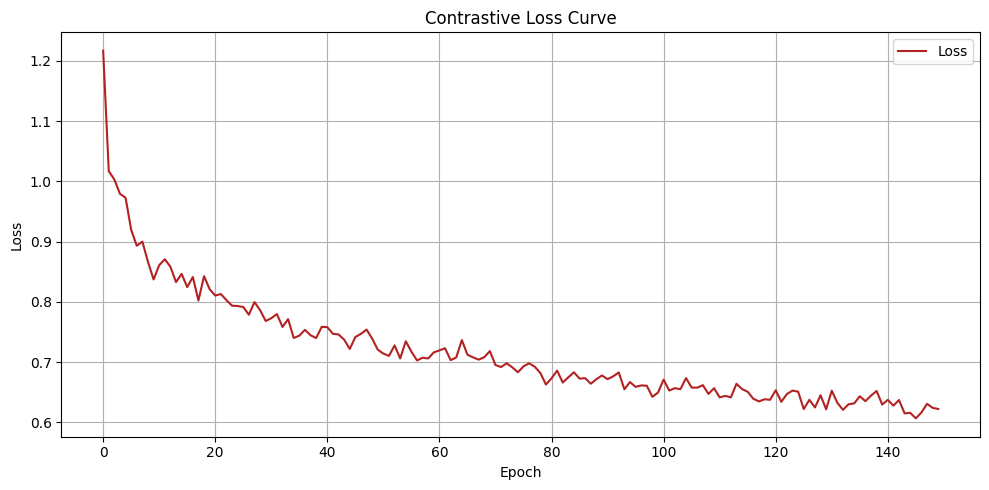

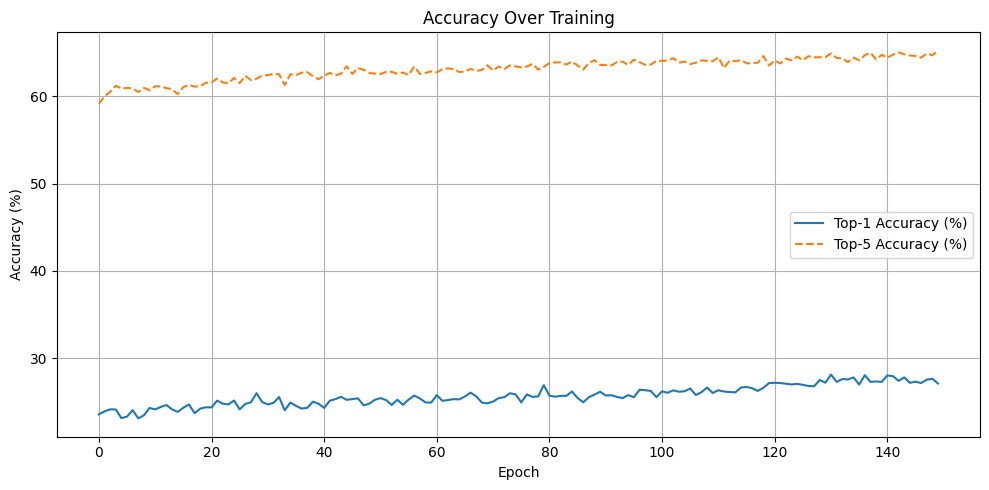

In [76]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

dataset = SingleFileEmbeddingPairDataset("C:\\Users\\Z0054udc\\Downloads\\Siamese GNN\\XT_merged_doubled.json")
print(f"Found {len(dataset)} dataset entries.")
if len(dataset) == 0:
    print("ERROR: No JSON files found !")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseGNN(in_dim=15, hidden_dim=64, out_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 150
loss_history = []
top1_history = []
top5_history = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_top1 = 0
    total_top5 = 0
    num_acc = 0

    for i in tqdm(range(len(dataset)), desc=f"Epoch {epoch+1}"):
        data1, data2, matches = dataset[i]
        data1 = data1.to(device)
        data2 = data2.to(device)
        matches = matches.to(device)

        optimizer.zero_grad()
        emb1, emb2 = model(data1, data2)
        loss = contrastive_loss(emb1, emb2, matches)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()
        total_loss += loss.item()

        # --- Accuracy tracking
        acc1 = batch_accuracy(emb1, emb2, matches)
        acc5 = batch_topk_accuracy(emb1, emb2, matches, k=5)
        if acc1 is not None and acc5 is not None:
            total_top1 += acc1
            total_top5 += acc5
            num_acc += 1

    avg_loss = total_loss / len(dataset)
    avg_top1 = (total_top1 / num_acc) * 100 if num_acc > 0 else 0.0
    avg_top5 = (total_top5 / num_acc) * 100 if num_acc > 0 else 0.0
    loss_history.append(avg_loss)
    top1_history.append(avg_top1)
    top5_history.append(avg_top5)

    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Top-1 = {avg_top1:.2f}%, Top-5 = {avg_top5:.2f}%")

# ---- Plotting after all epochs ----
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label="Loss", color='firebrick')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Contrastive Loss Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: plot Top-1/Top-5 accuracy curves too!
plt.figure(figsize=(10, 5))
plt.plot(top1_history, label="Top-1 Accuracy (%)")
plt.plot(top5_history, label="Top-5 Accuracy (%)", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Over Training")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [65]:
torch.save(model.state_dict(), "siamese_gnn.pth")
# To load: model.load_state_dict(torch.load("siamese_gnn.pth"))